## An Introduction to NetworkUnit
#### following the examples of comparing model implementations (C vs. SpiNNaker) and experimental data (monkey L vs. monkey N)

When considering model simulations and their evaluation, it is important
to precisely define the terminology and to be clear about the interpretation
of the results in order to judge the validity and the scope of applicability
of the model. For all practical purposes, in modeling one should be
concerned with its testable correctness relative to the given system
of interest, because only this process justifies its use as the basis
for analytic reasoning and prediction making.

In 1979 the Technical Committee on Model Credibility of the Society
of Computer Simulation established a widely recognized description
of a model verification and validation environment. We adapt this
terminology to the field of neural network modeling 
([*Trensch et al.* , sub.](#trensch2018); [*Gutzen et al.* , sub.](#gutzen2018)). 
The validation setup
is separated into three basic elements (see figure below).
The system of interest can be defined as "an entity, situation,
or system which has been selected for analysis" ([*Schlesinger et al.* ,1979.](#schlesinger1979)),
and constitutes the references against which validations are carried
out. When specifying this system of interest it is important to also
explicitly define the boundaries in which the modeling is expected
to be adequate. The modeling effort itself is separated into the definition
of the conceptual model, and its implementation as a computerized
model. The conceptual model is an abstract description formed by analysis
and observation of the system of interest. In the case of network
simulations, the conceptual model takes on the form of a mathematical
model describing the dynamics of neurons and the connectivity structure,
and other dynamic features of the simulation (e.g., inclusion of neuromodulatory
effects). An implementation of the conceptual mathematical model in
a computer software or in hardware, on the other hand, results in
a computerized, or more concretely for neural simulation, an executable
model.

The process of evaluating the degree to which the executable model is a correct
realization of the mathematical model is termed 'verification'.
In contrast, the comparison of the predictions generated by the computerized
model to the system of interest considering its intended domain of
applicability is the process called 'validation'. Together with
the process of 'confirmation', which attributes credibility to the
mathematical model as a useful description of the system of interest,
these three attributes form a circle that typically receives multiple
iterations consisting of improvements of the mathematical model and
its implementation as an executable model.

<div style='float:left; width:48%; display:inline-block'>
    <img src="../figures/validation_environment.png" width="100%" />
</div>
<div style='float:right; text-align:left; width:48%; display:inline-block'>
    <p><b>System of interest:</b> an entity, situation, or system which has been selected for analysis</p><br>
    <p><b>Mathematical model:</b> an abstract description formed by analysis and observation of the system of interest.</p><br>
    <p><b>Executable model:</b> an implementation of the mathematical model</p><br>
    <p><b>Confirmation:</b> attributing credibility to the mathematical model as a useful description of the system of interest.</p><br>
    <p><b>Validation:</b> a quantitative evaluation of usefulness and accuracy</p><br>
    <p><b>Verification:</b> evaluation whether the executable model is a correct realization of the mathematical model</p><br>
</div>

The NetworkUnit module builds upon the formalized validation scheme of the [SciUnit](https://github.com/scidash/sciunit) package, 
which enables the validation of *model*s against experimental data (or other models) via *tests*.
A test is matched to the model by *capabilities* and quantitatively evaluated by a *score*.
The following figure illustrates a typical test design within NetworkUnit. 
The blue boxes indicate the components of the implementation of the validation test, 
i.e. classes and class instances. The red boxes represent the data input, 
i.e. experimental data and parameter specifications. 
The relation between the boxes are indicated by annotated arrows. 
The relevant functionality of some components for the computation of test 
score is indicated by pseudo-code. The capability class `ProduceXY` contains 
the function `calc_xy()`. The test `XYTest` has a function `generate_prediction()` 
which makes use of this capability, inherited to the model class, 
to generate a model prediction. The initialized test instance `XYTest_paramZ` 
makes use of its `judge()` function to evaluate this model prediction and 
compute the score `TestScore`.

<div style='width:50%; display:block; margin-left:auto; margin-right:auto'>
        <img src="../figures/flowchart.png" width="100%" />
</div>

So far, we considered a scenario in which a model is compared to experimental
observations. However, there are circumstances in which a model is
the object of reference. This model could be another implementation
of the model under \edit{scrutiny}, an alternative model, or a different
simulation run of the same model. In the following, we explore such
validation scenarios, which we collectively *model-to-model
validation*. 

One possible scenario is the need to demonstrate the
equivalence of alternative implementations of the same model. These
implementations could, for example, be realized by different simulation
engines, like in our first example by a C simulation and a simulation on the SpiNNaker hardware.

<div style='width:50%; display:block; margin-left:auto; margin-right:auto'>
        <img src="../figures/flowchart_M2M.png" width="100%" />
</div>

In [1]:
%matplotlib inline
import sys
import os
import sciunit
import elephant
import numpy as np
from quantities import ms
from neo.core import SpikeTrain
from copy import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# How to add NetworkUnit to other projects

# !git clone https://github.com/INM-6/NetworkUnit.git
# !cd NetworkUnit/; git fetch; git pull

# sys.path.insert(0, './NetworkUnit')

In [2]:
sys.path.insert(0, '../') # sys.path.insert(0, 'path/to/networkunit')
from networkunit import models, tests, scores, plots, capabilities

### Validating a SpiNNaker simulation against a C simulation
For this comparison we use a polychronization network model ([*Izhikevich* , 2006](#izhikevich2006)) as it produces a rich repertoir of network dynamics. This model simulated with both a C implementation and an implementation on the neuromorphic SpiNNaker system.

The simulation data is available via [a GIN repository](https://web.gin.g-node.org/INM-6/network_validation) from which it can be loaded into the local storage with *git-annex* (or alternatively the gin-client).

In [26]:
# Clone gin repository 
!git clone git@gin.g-node.org:/INM-6/network_validation.git

# load simulation data
os.chdir('./network_validation')
!git-annex get ./simulation_data/iteration_III/60s_simulation_runs/*/out_firings_after5h.dat
os.chdir('..')

On a remote server it is only possible to download the data with `wget`.

In [27]:
!(echo "C/out_firings_after5h.dat" && echo "SpiNNaker/out_firings_after5h.dat") > download_files.txt
!wget -nH -nc -np -r -e robots=off -i download_files.txt -B https://web.gin.g-node.org/INM-6/network_validation/raw/master/simulation_data/iteration_III/60s_simulation_runs/
data_path = "./INM-6/network_validation/raw/master/simulation_data/iteration_III/60s_simulation_runs/"

--2018-09-07 11:48:06--  https://web.gin.g-node.org/INM-6/network_validation/raw/master/simulation_data/iteration_III/60s_simulation_runs/C/out_firings_after5h.dat
Resolving web.gin.g-node.org (web.gin.g-node.org)... 141.84.41.216
Connecting to web.gin.g-node.org (web.gin.g-node.org)|141.84.41.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘INM-6/network_validation/raw/master/simulation_data/iteration_III/60s_simulation_runs/C/out_firings_after5h.dat’

INM-6/network_valid     [    <=>             ]   6,86M  10,3MB/s    in 0,7s    

2018-09-07 11:48:07 (10,3 MB/s) - ‘INM-6/network_validation/raw/master/simulation_data/iteration_III/60s_simulation_runs/C/out_firings_after5h.dat’ saved [7193010]

--2018-09-07 11:48:07--  https://web.gin.g-node.org/INM-6/network_validation/raw/master/simulation_data/iteration_III/60s_simulation_runs/SpiNNaker/out_firings_after5h.dat
Reusing existing connection to web.gin.g-node.org:443.
HTT

#### The simulation is implemented in a model class
The model class should either be able to run the simulation or else load data from a simulation (what we do here).

In [28]:
class polychrony_data(models.spiketrain_data):
    file_path = '' # to be added in child class
    params = {'align_to_0': True,
              'filter_inh': True}
    
    def load(self, file_path, simulator, t_start=0, t_stop=60000, filter_inh=False, **kwargs):
        f = open(file_path, 'r')
        lines = f.readlines()
        
        N = 1000 # neurons 
        
        # Read Spike Times
        spike_times = [[]] * N
        for line in lines:
            sec, msec, n = line.split(' ')[:3]
            t = float(sec)*1000. + float(msec)
            n = int(n)
            if t > t_stop:
                break
            spike_times[n] = spike_times[n] + [t]

        # Fill Spike Trains
        nbr_neurons = N
        if filter_inh:
            nbr_neurons = 800
            
        spiketrains = [[]] * nbr_neurons
        for n, st in enumerate(spike_times):
            if n < 800:
                n_type = 'exc'
            else:
                n_type = 'inh'
            if not filter_inh or n_type == 'exc':
                spiketrains[n] = SpikeTrain(np.sort(st), units='ms', 
                                            t_start=t_start, t_stop=t_stop,
                                            n_type=n_type, unitID=n)
        return spiketrains

#### For the model-to-model comparison we derive a model class for each implementation

In [29]:
# C simulation
class C_sim(polychrony_data):
    file_path = data_path + 'C/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#2173a3', simulator='C')
    
# SpiNNaker simulation    
class S_sim(polychrony_data):
    file_path = data_path + '/SpiNNaker/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')

In [30]:
C = C_sim(name='C')
S = S_sim(name='SpiNNaker')

#### Show the spiking activity data

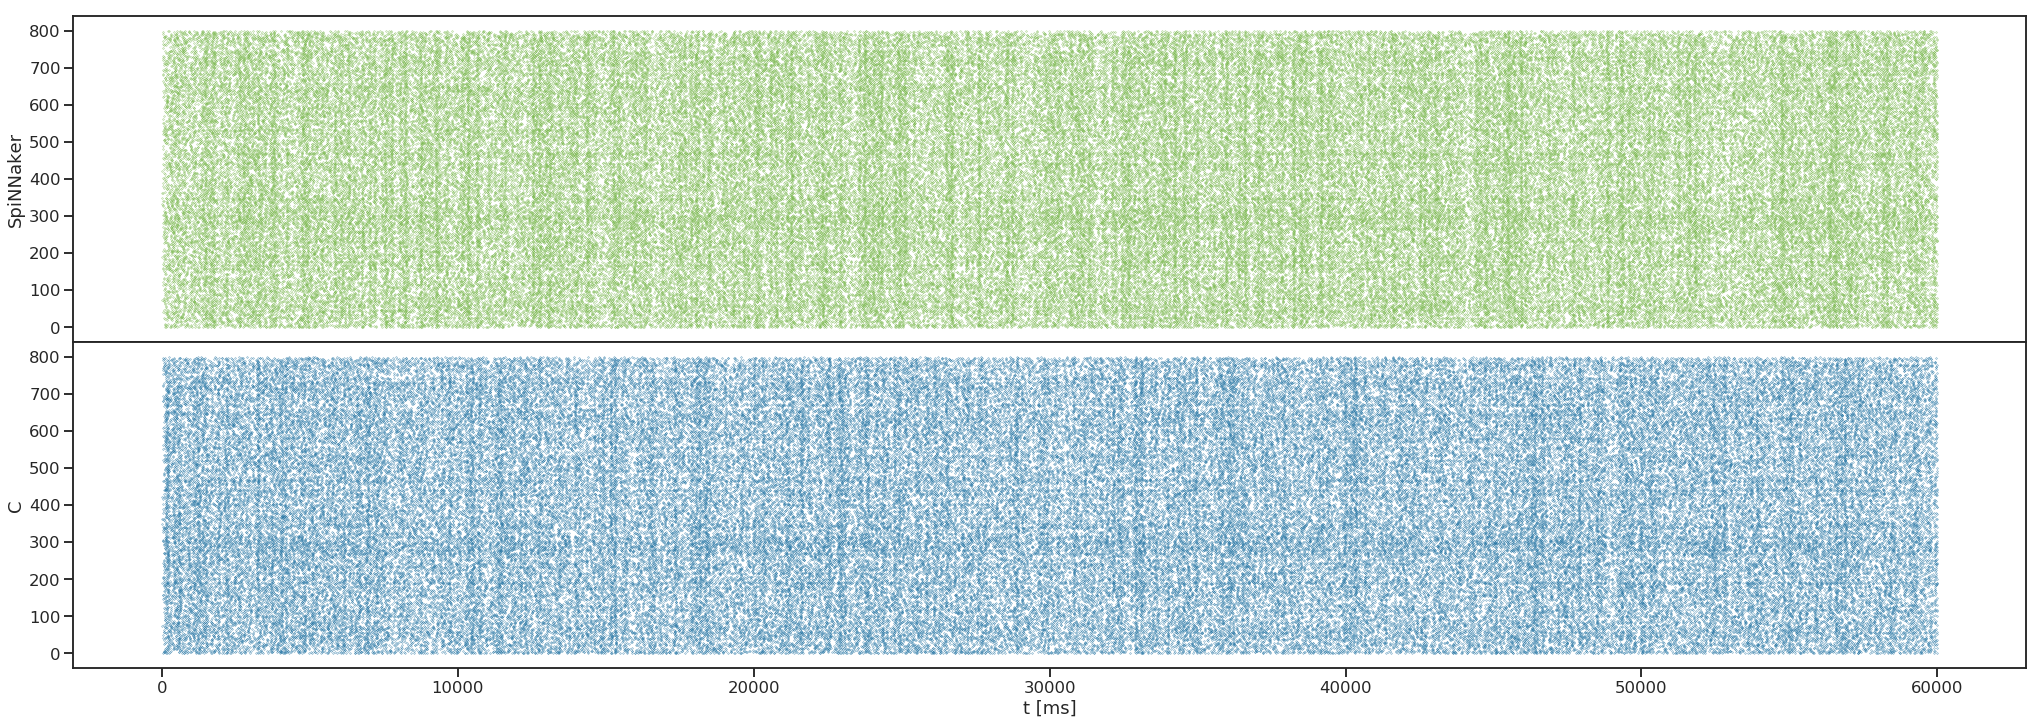

In [35]:
fig, ax = plt.subplots(nrows=2, sharex=True, 
                       gridspec_kw={'hspace':0}, 
                       figsize=(35,12))

for sim_count, sim in enumerate([S, C]):
    sim.produce_spiketrains()
    for st_count, st in enumerate(sim.spiketrains):
        ax[sim_count].scatter(st, [st_count]*len(st), 
                              color=sim.params['color'], 
                              marker='.', s=.5)
        
    ax[sim_count].set_ylabel(sim.name)
ax[-1].set_xlabel('t [ms]');

#### Test definitons
The validation tests are also defined as classes. NetworkUnit offers a variety of base tests from which tests can be derived.

In [36]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.effect_size
    
class LV_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'lv'}
    
FR_test = FR_test_class()
LV_test = LV_test_class()

#### What can tests do?
... every test has a function generate_prediction() which calculates the test measure

In [37]:
FR_test.generate_prediction(C)

[array(2.41666667) * Hz,
 array(2.85) * Hz,
 array(3.1) * Hz,
 array(3.63333333) * Hz,
 array(2.5) * Hz,
 array(2.51666667) * Hz,
 array(2.53333333) * Hz,
 array(4.75) * Hz,
 array(1.83333333) * Hz,
 array(2.76666667) * Hz,
 array(1.91666667) * Hz,
 array(2.73333333) * Hz,
 array(1.76666667) * Hz,
 array(3.73333333) * Hz,
 array(2.56666667) * Hz,
 array(2.03333333) * Hz,
 array(2.5) * Hz,
 array(2.65) * Hz,
 array(2.31666667) * Hz,
 array(2.93333333) * Hz,
 array(2.1) * Hz,
 array(1.83333333) * Hz,
 array(2.26666667) * Hz,
 array(3.06666667) * Hz,
 array(3.7) * Hz,
 array(2.25) * Hz,
 array(4.71666667) * Hz,
 array(2.58333333) * Hz,
 array(1.46666667) * Hz,
 array(3.03333333) * Hz,
 array(1.1) * Hz,
 array(2.58333333) * Hz,
 array(3.36666667) * Hz,
 array(2.68333333) * Hz,
 array(1.9) * Hz,
 array(1.86666667) * Hz,
 array(2.76666667) * Hz,
 array(3.01666667) * Hz,
 array(3.2) * Hz,
 array(2.08333333) * Hz,
 array(2.6) * Hz,
 array(3.16666667) * Hz,
 array(2.83333333) * Hz,
 array(3.3) 

#### What can tests do?
... the test classes are also able to visualize the the generated samples.

No handles with labels found to put in legend.


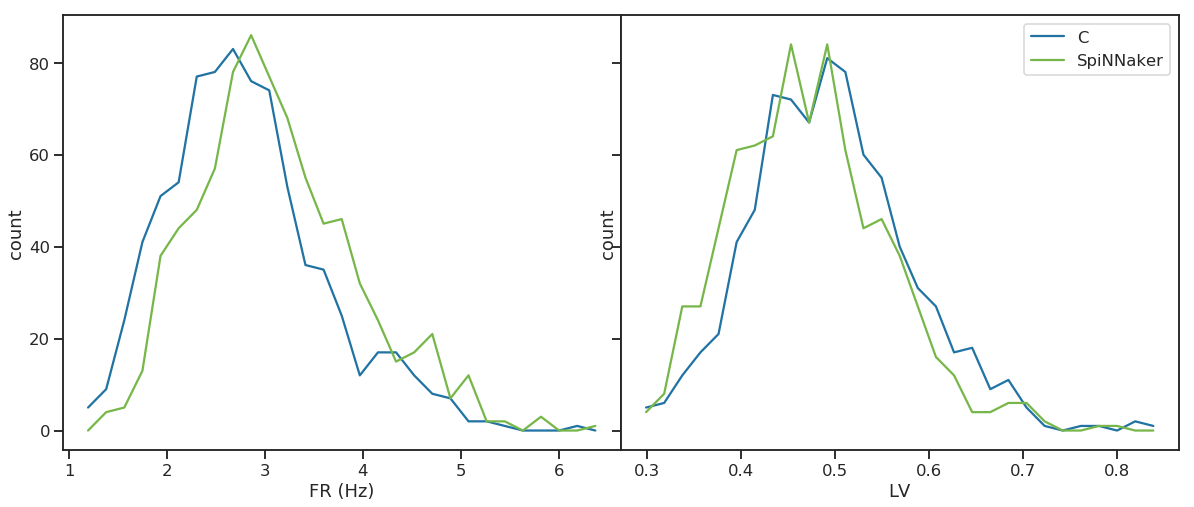

In [40]:
fig, ax = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0}, figsize=(20,8))

FR_test.visualize_samples(C, S, ax=ax[0], var_name='FR (Hz)', bins=30, density=False)
LV_test.visualize_samples(C, S, ax=ax[1], var_name='LV', bins=30, density=False);

#### What can tests do? 
... to perform the actual validation and calculate a test score, you call the judge() function, which will
    1. check if the model has all the required capabilities.
    2. call generate_prediction()
    3. call compute_score()
    4. check that the score is of score_type
    5. equip the score with metadata
    6. returns the score.

In [41]:
# For a model-to-model test the two models are passed as a list
print('FR test:\n', FR_test.judge([C, S]).score)

FR test:
                   C  SpiNNaker
C          0.000000   0.394106
SpiNNaker  0.394106   0.000000


In [44]:
# to access an element of the score DataFrame use
print('FR-Test ', FR_test.judge([C, S]).iloc[1,0])
print('LV-Test ', LV_test.judge([C, S]).iloc[1,0])
# print of a score instance invokes the __str__ property of the test

FR-Test  

Effect Size
	datasize: 800 	 800
	Effect Size = 0.394 	 CI = (0.295, 0.493)


LV-Test  

Effect Size
	datasize: 800 	 800
	Effect Size = 0.271 	 CI = (0.172, 0.369)




#### Using a different statistical test as score type is as simple as

In [46]:
class FR_ks_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.ks_distance # students_t, kl_divergence, mwu_statistic, best_effect_size, LeveneScore

FR_ks_test = FR_ks_test_class()

print(FR_ks_test.judge([C, S]).iloc[1,0])



Kolmogorov-Smirnov-Distance
	datasize: 800 	 800
	D_KS = 0.185 	 p value = 1.82e-12




### That's all good and fine but what about experimental data !?!?!?

Intro for comparison

In [ ]:
# Clone repository (this will not download large data files)
!gin get doi/multielectrode_grasp

# download large data files needed for this example
os.chdir('./multielectrode_grasp')
!gin get-content ./datasets/l101210-001.odml # metadata for monkey L
!gin get-content ./datasets/l101210-001.ns2 # analog signals for monkey L
!gin get-content ./datasets/l101210-001.ccf
!gin get-content ./datasets/l101210-001.nev # unsorted spike times for monkey L
!gin get-content ./datasets/l101210-001-02.nev # sorted spike times for monkey L
!gin get-content ./datasets/i140703-001.odml # metadata for monkey I
!gin get-content ./datasets/i140703-001.ns2 # analog signals monkey I
!gin get-content ./datasets/i140703-001.ccf
!gin get-content ./datasets/i140703-001.nev # unsorted spike times for monkey I
!gin get-content ./datasets/i140703-001-03.nev # sorted spike times for monkey I
os.chdir('..')

# add to path
sys.path.insert(0, './multielectrode_grasp/code/python-neo')
sys.path.insert(0, './multielectrode_grasp/code/python-odml')
sys.path.insert(0, './multielectrode_grasp/code/reachgraspio')
sys.path.insert(0, './multielectrode_grasp/code')

#### load the data and utility functions

In [3]:
!( echo "code/reachgraspio/reachgraspio.py" \
&& echo "code/neo_utils.py" \
&& echo "datasets/l101210-001.odml" \
&& echo "datasets/l101210-001.ns2" \
&& echo "datasets/l101210-001.nev" \
&& echo "datasets/l101210-001-02.nev" \
&& echo "datasets/i140703-001.odml" \
&& echo "datasets/i140703-001.ns2" \
&& echo "datasets/i140703-001.ccf" \
&& echo "datasets/i140703-001.nev" \
&& echo "datasets/i140703-001-03.nev") \
> download_files.txt
!wget -nH -nc -r -np -e robots=off -i download_files.txt -B https://web.gin.g-node.org/doi/multielectrode_grasp/raw/master/
download_path = "./doi/multielectrode_grasp/raw/master/"
data_path = download_path + 'datasets/'

File ‘doi/multielectrode_grasp/raw/master/code/reachgraspio/reachgraspio.py’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/code/neo_utils.py’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/l101210-001.odml’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/l101210-001.ns2’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/l101210-001.nev’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/l101210-001-02.nev’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/i140703-001.odml’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/i140703-001.ns2’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/i140703-001.ccf’ already there; not retrieving.

File ‘doi/multielectrode_grasp/raw/master/datasets/i140703-001.nev’ already there; not retrie

#### load odml and add everything to the python path

In [6]:
#!wget https://github.com/G-Node/python-odml/archive/version_1.2.zip
#!unzip version_1.2.zip
os.chdir("./python-odml-version_1.2")
!python setup.py install
os.chdir('../')

running install
running bdist_egg
running egg_info
creating odML.egg-info
writing odML.egg-info/PKG-INFO
writing dependency_links to odML.egg-info/dependency_links.txt
writing requirements to odML.egg-info/requires.txt
writing top-level names to odML.egg-info/top_level.txt
writing manifest file 'odML.egg-info/SOURCES.txt'
reading manifest file 'odML.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'odML.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/odml
copying odml/value.py -> build/lib/odml
copying odml/doc.py -> build/lib/odml
copying odml/__init__.py -> build/lib/odml
copying odml/property.py -> build/lib/odml
copying odml/section.py -> build/lib/odml
copying odml/terminology.py -> build/lib/odml
copying odml/base.py -> build/lib/odml
copying odml/types.py -> build/lib/odml
copying odml/mapping.py -> build/lib/odml
copying odml

byte-compiling build/bdist.linux-x86_64/egg/odml/gui/__main__.py to __main__.cpython-36.pyc
byte-compiling build/bdist.linux-x86_64/egg/odml/gui/SectionView.py to SectionView.cpython-36.pyc
  File "build/bdist.linux-x86_64/egg/odml/gui/SectionView.py", line 76
    def add_section(self, widget, (obj, section)):
                                  ^
SyntaxError: invalid syntax

byte-compiling build/bdist.linux-x86_64/egg/odml/gui/CommandManager.py to CommandManager.cpython-36.pyc
  File "build/bdist.linux-x86_64/egg/odml/gui/CommandManager.py", line 7
    print "run", cmd
              ^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print("run", cmd)?

byte-compiling build/bdist.linux-x86_64/egg/odml/gui/NavigationBar.py to NavigationBar.cpython-36.pyc
  File "build/bdist.linux-x86_64/egg/odml/gui/NavigationBar.py", line 91
    print "change event(document): ", context
                                   ^
SyntaxError: invalid syntax

byte-compiling build/bdist.linux-x86

removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing odML-1.2.1-py3.6.egg
Copying odML-1.2.1-py3.6.egg to /home/rgutzen/anaconda3/envs/py36/lib/python3.6/site-packages
Removing odML 1.4.1 from easy-install.pth file
Adding odML 1.2.1 to easy-install.pth file
Installing odml-gui script to /home/rgutzen/anaconda3/envs/py36/bin

Installed /home/rgutzen/anaconda3/envs/py36/lib/python3.6/site-packages/odML-1.2.1-py3.6.egg
Processing dependencies for odML==1.2.1
Searching for enum
Reading https://pypi.org/simple/enum/
Best match: enum 0.4.7
Processing enum-0.4.7.tar.gz
Writing /tmp/easy_install-yzo4_qym/enum-0.4.7/setup.cfg
Running enum-0.4.7/setup.py -q bdist_egg --dist-dir /tmp/easy_install-yzo4_qym/enum-0.4.7/egg-dist-tmp-6s97wigl
Traceback (most recent call last):
  File "/home/rgutzen/anaconda3/envs/py36/lib/python3.6/site-packages/setuptools/sandbox.py", line 154, in save_modules
    yield saved
  File "/home/rgutzen/anaconda3/envs/py36/lib/python3.6/site-package

In [19]:
sys.path.insert(0, './python-odml-version_1.2')
sys.path.extend((download_path + 'code',
                 download_path + 'code/reachgraspio'))
from neo_utils import add_epoch, cut_segment_by_epoch, get_events
import reachgraspio as rgio

In [24]:
!pip show odml

Name: odML
Version: 1.2.1
Summary: open metadata Markup Language
Home-page: http://www.g-node.org/projects/odml
Author: Hagen Fritsch
Author-email: fritsch+gnode@in.tum.de
License: UNKNOWN
Location: /home/rgutzen/anaconda3/envs/py36/lib/python3.6/site-packages/odML-1.2.1-py3.6.egg
Requires: enum, lxml
Required-by: 


In [25]:
import odml
odml.__version__

'1.4.1'

#### Define model classes as wrappers for the experimental data

In [21]:
class exp_data(models.experimental_data, capabilities.ProducesSpikeTrains):
    """
    A model class to load data from reach2grasp experiment. Spike times from the
    complete recording sessions are loaded.
    """

    def load(self, datfile, **kwargs):
        """
        Loads data from datfile.
        """        
        # set paths
        fpath = data_path + datfile
        print('loading data from ' +fpath +'.nev')
        print('this may take a minute..')
        # load session and get event times
        session = rgio.ReachGraspIO(fpath, odml_directory=data_path)
        block = session.read_block(nsx_to_load='all', units='all', load_events=True, scaling='voltage')
        data_segment = block.segments[0]
        start_event = get_events(data_segment, properties={
                'trial_event_labels': self.params['start_trigger'],
                'performance_in_trial': session.performance_codes['correct_trial']})[0]
        stop_event = get_events(data_segment, properties={
                'trial_event_labels': self.params['stop_trigger'],
                'performance_in_trial': session.performance_codes['correct_trial']})[0]
        # select segments and get spiketrains
        selected_trial_segments = self.select_trial_segments(data_segment, start_event, stop_event)
        spiketrains = self.get_spiketrains(selected_trial_segments)
        
        return spiketrains
    
    
    def select_trial_segments(self, data_segment, start_event, stop_event, **kwargs):
        '''
        Filters out trials from given data_segment
        ''' 
        epoch = add_epoch(data_segment, event1=start_event, event2=stop_event, attach_result=False)        
        cut_trial_block = neo.Block(name="Cut_Trials")
        cut_trial_block.segments = cut_segment_by_epoch(data_segment, epoch, reset_time=True)
        selected_trial_segments = []
        for tr_typ in self.params['trial_types']:
            selected_trial_segments.extend(cut_trial_block.filter(targdict={'belongs_to_trialtype': tr_typ}, 
                                                                  objects=neo.Segment))
        self.n_trials = len(selected_trial_segments)
        self.n_units = len(selected_trial_segments[0].filter({'sua': True}))
        return selected_trial_segments
        
        
    def get_spiketrains(self, selected_trial_segments, **kwargs):
        '''
        Appends all spike trains in selected_trial_segments to a list
        of spike trains. Spike trains with SNR<2.5 are sorted out.
        '''
        spiketrains = []
        for seg_id, seg in enumerate(selected_trial_segments):
            # Discarding non-valid trials
            if seg.annotations['trial_id'] == -1:
                continue
            # Selecting only the SUAs
            for st in seg.filter({'sua': True}):
                # Check the SNR, only use units with SNR>2.5 (see Brochier et al, 2018)
                if st.annotations['SNR'] > 2.5:
                    st.annotations['trial_id'] = seg.annotations['trial_id']
                    st.annotations['trial_type'] = seg.annotations['belongs_to_trialtype']
                    st.annotate(trial_id_trialtype=seg_id)
                    spiketrains.append(st)
        return spiketrains

In [22]:
# Monkey L
class exp_class_L(exp_data):
    datfile = 'l101210-001'
    params = {'start_trigger': 'TS-ON',
              'stop_trigger': 'CUE-ON',
              'trial_types': ['PGLF', 'PGHF', 'SGLF', 'SGHF'],
              'color': sns.color_palette('Set1')[0]
              }
    
# Monkey I
class exp_class_I(exp_data):
    datfile = 'i140703-001'
    params = {'start_trigger': 'TS-ON',
              'stop_trigger': 'CUE-ON',
              'trial_types': ['PGLF', 'PGHF', 'SGLF', 'SGHF'],
              'color': sns.color_palette('Set1')[1]
              }

In [23]:
L = exp_class_L(name='Monkey L')
I = exp_class_I(name='Monkey I')

loading data from ./doi/multielectrode_grasp/raw/master/datasets/l101210-001.nev
this may take a minute..


InvalidVersionException: Cannot parse odML document with format version '1'. 
	Use the 'tools.VersionConverter' to import previous odML formats.

In [15]:
import odml
odml.__version__

'1.4.1'

### We use the same tests as before to compare the data sets

In [ ]:
print('FR-Test ', FR_test.judge([C, S]).iloc[1,0])
print('LV-Test ', LV_test.judge([C, S]).iloc[1,0])

<p><i>"A model, like a novel, may resonate with nature, but it is not a 'real' thing. Like novel, a model may be convinving - it may 'ring true' if it is consistent with our experience of the natural world. But just as we may wonder how much the characters in a novel are drawn from real life and how much is artifice, we might ask the same of a model: How much is based on observation and measurement of accesssible phenomena, how much is based on informed judgment, and how much is convencience?"</i></p>
<p style="float:right">Orsekes, 1994</p>


### References

Gutzen et al. (2018) Reproducible neural network simulations: model validation on the level of network activity data, Frontiers in Neuroinformatics, submitted<a id='gutzen2018'></a>